# **COLLABORATE & COMPETE** - Tennis

### *Implementation for Udacity Deep Reinforcement Learning*
***

##### Load a few extensions before doing anything else...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

# Project Overview, Results, & To-Do

## Agent overview
    
### **MAD4PG**
    
This codebase implements a modified version of **[Multi-agent Actor-Critic for Mixed Cooperative-Competitive Environments (MADDPG)](https://arxiv.org/abs/1706.02275)**, a state-of-the-art multi-agent learning algorithm published by OpenAI.

> MADDPG presents a rigorous theoretical background for how multiple DDPG agents can interact and learn in the same environment, presenting solutions to non-stationary environments and estimating unknown adversary policies, as well as an approach to more robust and stable training utilizing _ensemble policies_. 

It is combined with _[Distributed Distributional Deep Deterministic Policy Gradient (D4PG)](https://arxiv.org/pdf/1804.08617.pdf)_ 

>D4PG uses distributed training, distributional value estimation, n-step bootstrapping, and an Actor-Critic architecture to provide fast, stable training in a continuous action space for which traditional Q-value estimation would fail.

To create a network type I call _**MAD4PG**_.


### **D4PG**

The paper introducing D4PG introduces several key improvements over the DDPG algorithm on which is it based:
* K-Actor distributed training
* Prioritized Replay buffer
* N-Step Rollout/Bootstrapping
* Distributional Value Estimation

In my opinion, the most important addition here is the **Distributional Value Estimation**. The other steps have been studied and/or implemented in other papers or textbooks, and feel more evolutionary to the DDPG algorithm than a truly new algorithm.

>_**Distributional Value Estimation**_ allows the agent to not just estimate the value of a given action, but to estimate the probability of a value, thus allowing for uncertainty in the return. I certainly feel, and agree with the research that posits the idea, that allowing an agent to say "This is X% likely to result in this value, but also Y% in this other value" is much more like how a human, or intelligent creature, learns. At the very least it adds robustness to training by allowing for further complexity in comparing online and offline network estimations and thus improves loss calculations.
>
>_**Categorial Projection**_ is key to the implementation of the distributional portion of this algorithm and ensures that the >discretization of the target and local rewards correlate in a mathematically correct manner. The math here requires further study, but the papers above and certain repositories credited in the code were helpful in implementing the methodology.  
>
>This portion of the research is credited to [_"A Distributional Perspective on Reinforcement Learning"_](https://arxiv.org/pdf/1707.06887.pdf) And should be considered a must-read for anyone interested in the concept.  

The D4PG paper suggested that **Prioritized Experience Replay (PER)** did not result in demonstrable improvements in training, and thus, it was not implemented here. The results achieved by this agent do not seem to suffer for it's lack, but it would be good to test with and without to be thorough in evaluating training performance.

This agent does use **N-Step Bootstrapping** as described in the paper. N-Step bootstrapping performs Temporal-Difference (TD) Learning across N steps instead of a single SARS' tuple. In a plentiful-reward environment such as _Reacher_, removing uncertainty from value estimation is a huge win, and while I did not run trials of differing values for `N`, it is likely that larger values would have some positive effect, similarly to a PPO agent.

D4PG is itself an evolution out of the paper [_"Continuous Control with Deep Reinforcement Learning (DDPG)"_](https://arxiv.org/pdf/1509.02971.pdf).

>DDPG is an architecture which allows for an **Actor** network to estimate a deterministic action policy while determining the _value_ of that action using a **Critic** network that outputs a Q-value by using the Action as part of the input.



### Because who doesn't like to see the results before the details...

Below are four graphed results, including the losses for both agents. Due to limitations in notebooks/markdown, these graphs are a little small, you can click on them in markdown, or open them in the `images/` folder in the repository to see more detail.

The agent training was able to achieve a score of +0.5 easily and relatively rapidly, however, an agent achieving this average score still performs unacceptably in evaluation mode. To combat this, I began requiring the agent to achieve at least +1.0, at which point the agents could easily play perfectly in evaluation mode.

Notice that this environment tended to have a hard takeoff... that it took awhile for agents to learn how to hit a ball a single time, but once they did, they could usually do so reliably. The instability after that point is usually due to the noise added to the action output.

This agent did have an early termination implementation, as well as episode score-cap functionality. This helped to eliminiate unecessarily long training sessions, as it was a fairly slow learning process.

![MAD4PG_v1_graph.png](images/MAD4PG_v1_graph.png)
![MAD4PG_v2_graph.png](images/MAD4PG_v2_graph.png)
![MAD4PG_v3_graph.png](images/MAD4PG_v3_graph.png)
![MAD4PG_v4_graph.png](images/MAD4PG_v4_graph.png)

### Hyper Parameters


Although the D4PG algorithm is robust to a very wide variety of hyperparameters, **MAD4PG as applied to the _Tennis_ environment proved to be fairly sensitive.**

Training tended to take a long time and would not progress until a hard-takeoff point where the agents learned to hit the ball at least once, which proved time consuming.

Over time, it was learned that reducing the `LEARNING RATEs` was key to good performance. The timesteps between network updates had a large effect as well, needing a fairly specific range of `TAU` or `C`, or training would never improve. Additionally, tuning the `VMAX` parameter also proved key to getting good results.

Additionally, there is a massive variance in results between trials with identical parameters. Take a closer look at the first two graphs, which were run with identical parameters... the second trial took close to 70% longer to solve the environment to quit conditions! 

Interestingly, despite this environment seemingly being much more simple than the _Reacher_ arm environment, that environment proved significantly easier and faster to train. This is perhaps a testament to the difficulty of learning in a stochastic, multi-agent world.

* **`ACTOR_LEARN_RATE / CRITIC_LEARN_RATE`** - Tests were run on values of 0.01-0.00005 for both values, but it was not until running trials with quite small rates that training reliably proceeded. The sweet spot is around 0.00025 for the **actor**, and 0.0005 for the **critic**. The Actor network should _always_ learn at a slower rate than the Critic, for stability. It would be a good goal for future work to test this out in a rigorous way, but all networks created for this class have thus far performed best when Actor is 50-75% of the Critic learning rate.


* **`C/TAU`** - I have consistently, across all projects, found that a HARD update type utilizing a parameter C controlling how many timesteps between updates, gives me superior performance over soft-update style gradual target network updating using parameter TAU. In the training for this agent, C is consistently set around 2500. TAU was only successfuly in a range around 0.0001. The discrepancy between hard updates and soft updates is interesting and merits further study.


* **`E`** - Tuning `E` was challenging for this environment, in that allowing it to continue at a high rate for very long made training take a very long time. These agents are extremely sensitive to noise in their action choices. That being said, without an adequate amount of noise, they would never explore adequately to learn their tasks. Thus, it was important to anneal `E` to a low value in tandem with the rate of return that the agents received. There is an entire section on this implementation below, in the code details.


* **`PRETRAIN`** - Increasing `pretrain` to a high value ensured that there was adequate experience from which to learn from early on, and meant that much random experience was available to draw upon while `E` annealed with score. Filling the buffer can be extremely fast, as there is no need to run either the Actor network, or any backpropogation. Random actions suffice to provide learnable experience. It would be interesting to run trials with an extremely high (200,000 or more) number of random pretraining steps, and a much lower rate for `E` and see whether the agent learned more rapidly this way.


* **`ROLLOUT`** - N-Step Bootstrapping/Rollout should be key to the performance of these agents, allowing them to anticipate movements ahead of time. A good future experiment would be to increase the amount of rollout to several 10s of timesteps and compare performance. This would be approaching a strict policy gradient style update, and I'd be curious to see how it worked out.


* **`L2_DECAY`** - Adding a very small Adam Optimizer l2 decay seemed to be a benefit, this parameter was never tuned in a meaningful way.


* **`ATOMS`** - Atoms/Num_Atoms controls the granularity with which the probability distribution is estimated from the Q-network. More Atoms equals a finer-grained discretization of the curve. Note that _**more atoms does not equal better performance**_. The D4PG paper suggested that 51 atoms was a sweet spot for their tasks, while I found 75-101 atoms to be more efficacious in this task, for whatever reason. More than 101 atoms negatively affected performance. There is likely further research to be done, or read up upon if someone has already performed it, on the relationship between action complexity, reward density, and the number of `atoms` which is effective.


* **`VMIN / VMAX`** - _vmin_ and _vmax_ are the bounds on the values predicted by the Agent. The `atoms` are distributed between these two values, which are in turn multiplied by the probabilities from the Critic network to arrive at the value distribution. Because there are no negative rewards in this environment, the value for `vmin` must necessarily be set to -0.1, the lowest value of any state/action, because the episode terminates if this reward is received. 

    >The value for `vmax` is  more ephemeral... the maximum value for a timestep is 0.1, however, the value function estimates _total return_, and due to the categorical projection step, the current _real rewards_ are added to the value distribution estimation, and bounded by `vmax` as well. Thus, an argument could be made that `vmax` should be set to the theoretical maximum episode score for the environment. Interestingly, and in contrast to the _Reacher_ environment, it was found later in trials that setting `vmax` to a suitably high number was in fact beneficial to training. Any value below 0.5 hampered training and often prevented convergence. A value of between 1 and 2 seemed to be very effective.

### Future Ideas
_**Unique to MAD4PG**_
* I would like to throw this agent against a more complex task (like the Soccer environment) that requires more competition, and test its ability to devise strategy, and not just learn a deterministic environment.
* I ran dozens of trials on this environment and only near the end did I begin to get really consistent results that seemed to tease out more stable, quick learning results. If computing time/resources allow, it would be good to continue to run trials to determine how robust is the agent to additional parameter variation.
* I would like to implement different frameworks of multi-agent learning to see how they perform vis a vis MAD4PG. 
* It would also be a great exercise to pit differing frameworks against each other, this would:
    * Be interesting to see the relative strengths and weaknesses of differing frameworks
    * Require opposing-agent policy estimation which would be a good exercise in and of itself
* It would be beneficial to implement robust _ensemble policies_ for more stable and faster training.

_**General D4PG**_
* **Categorical Projection** is the step by which the target values are projected onto the supports defined by the local value function. The math and concepts here stretched the limits of my knowledge, and while I grasp the concepts, I would very much like to achieve a deeper understanding of the mathematical principals and implementation.
* [**Prioritized Experience Replay (PER)**](https://arxiv.org/abs/1511.05952) was implemented in my DQN agent, but never fully tested. I believe that for complex tasks like this _Reacher_ environment, or perhaps moreso to the optional _Crawler_ environment, utilizing PER could provide measurable speedup in learning rate. 
* As explored above in the hyperparameter section, the relationship between `VMIN/VMAX` and the environment rewards merits further study and understanding.
* The relationship between action complexity and `atoms` also merits further understanding.
* I implemented a D4PG agent as opposed to the base DDPG algorithm because it was newer, presented more challenges, and had less (to none) GitHub examples available, especially in PyTorch. It was well worth the effort required to read, understand, and implement the algorithm. However, it would be good to compare performance with DDPG itself! While D4PG seems to achieve superior results to the instructor provided benchmarks, and learns very quickly and stably in this environment, the extent to which it is or is not superior to DDPG is unclear without a direct comparison to trial.
* **PPO/TRPO algorithms** would be good to implement as further comparisons and to add to my tool chest. While I understand Policy Based methods, there is no substitute for _doing_, and to round out my knowledge of the current state-of-the-art, having hands-on experience with these methods would be beneficial.
* I believe D4PG has a wide variety of applications to other tasks, especially difficult tasks for which brute-force policy methods might fail. I look forward to running this agent in as many environments as time permits.
* **Parameter Noise** is a process by which noise is added to the network weights instead of as a constant applied to the network output. OpenAI has pioneered this process with their paper [_Parameter Space Noise for Exploration_](https://arxiv.org/abs/1706.01905). While this agent quickly converges to an optimal policy in the current implementation, it would be worthwhile to explore parameter noise, as it may be more relevant to more complex tasks such as locomotion.

## Click below to watch the trained Agent!
[!["Trained Agent"](http://img.youtube.com/vi/LtwvajchiIc/0.jpg)](https://youtu.be/LtwvajchiIc "Tennis")

# Implementation Details

_This code represents a much more mature, flexible implementation of all of the code I have written for the Udacity DeepRL class. I look forward to adapting it to other environments._

## Initialize Imports
This Notebook uses code from separate python files where most of the implementation is handled

In [3]:
import numpy as np
from agent import MAD4PG_Net
from environment import Environment
from data_handling import Logger, Saver, gather_args

## Implement **`MAIN.PY`**
####  _This implementation was originally intended to be run on the command-line, so we'll need to import the functions from **`main.py`** and explore._

### Simulate a command line **`Args`**
Commandline arguments run the entire show, we'll have to simulate a command line entry.

In [4]:
cmd_args = "--num_episodes 1200 --actor_learn_rate 0.00025 --critic_learn_rate 0.0005 --C 2500 --vmin 0 --vmax 1.3"

In [5]:
args = gather_args(cmd_args.split())

Let's check out what arguments have been loaded...

In [6]:
print_args(args)

eval: False
force_eval: False
nographics: False
quiet: False
verbose: False
observe: False
layer_sizes: [350, 250]
actor_learn_rate: 0.00025
critic_learn_rate: 0.0005
gamma: 0.99
update_type: soft
C: 2500
tau: 0.0001
e: 0.3
e_min: 0.0
anneal_max: 0.7
e_decay: 1
vmin: 0.0
vmax: 1.3
num_atoms: 101
batch_size: 128
buffer_size: 300000
pretrain: 128
rollout: 5
cpu: False
num_episodes: 1200
max_steps: 1000
quit_threshold: 0.525
print_every: 50
log_every: 50
resume: False
save_dir: saves
save_every: 100
device: cuda:0
train: True


### Set up the **`Environment`**
Now that args are loaded, we can load the environment.

In [7]:
env = Environment(args)

LOADING ON SYSTEM: Windows
##################################################
#                                                #


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


#                                                #
##################################################


Print some information about the environment.

In [8]:
print("Num Agents:", env.agent_count)
print("Action size:", env.action_size)
print("State size:", env.state_size)

Num Agents: 2
Action size: 2
State size: 24


#### Take random actions in the Environment
* Check that the environment is working
* Test commands and see the results!

While testing out the environment, set training mode to False, and limit max_steps to ensure it doesn't run too long for testing purposes.

Keep in mind that for this environment, all tensors are stacked 20-high! One for each Arm in the environment.

In [9]:
env.train = False
env.reset()
num_eps = 1
state = env.states
env.reset()
for _ in range(50):
    score = np.zeros(env.agent_count)
    actions = np.random.uniform(-1, 1, (env.agent_count, env.action_size))
    next_state, reward, done = env.step(actions)
    state = next_state

In [10]:
print_env_info(state[0], actions[0], reward[0])

The agent chooses ACTIONS that look like:
[0.98847915 0.50162165]

The environment returns STATES that look like:
tensor([ -6.1158,  -1.8524, -29.8729,   0.0000,  -7.0884,   5.2544, -29.8729,
          0.0000,  -5.7742,  -1.8522,   3.4157,   0.0000,  -7.0884,   4.8228,
          3.4157,   0.0000,  -2.8088,  -1.1836,  29.6544,   6.4114,  -7.0884,
          4.2931,  29.6544,   6.4114])

The environment returns REWARDS that look like:
0.0


## Evaluate a trained Agent

Let's see a trained agent in action! Because this environment can drag on very boringly, this evaluation is limited to 200 timesteps.

Preview in this notebook using:

In [11]:
notebook_eval_agent(args, env, ["weights/MAD4PG_v1_agent1.agent", "weights/MAD4PG_v1_agent2.agent"], num_eps=1)

Score: 0.5000000074505806


**Or on the commandline, run the following command:**  
**`python main.py -eval -savedir weights`**  
*If you wish to see more than two episodes of evaluation, try this:*  
**`python main.py --force_eval -num 5 -savedir weights`**  

You will be prompted to load a file on the command line.

Note that the Agent weights require the same network setup for loading as when they were training, this affects `layer_sizes` and `num_atoms`. If you receive a mismatch error, be sure to explicitly flag the correct parameters from the command line. You can determine the correct values easily from the error. The saved weights provided in this repository match the default values for command line parameters.

## Training
Now that the initial setup is created, training is as simple as running the **`train()`** routine. We'll take a look inside each step below.

For Notebook purposes, saving has been disabled. Closing the environment is also disabled because the environment errors if closed and reopened in the Notebook.

### Load the **`Agent`** and **`Saver`** objects
* The MAD4PG_Agent object initializes `num_agents` amount of agents (2 for _Tennis_), and contains much of the methods necessary to train.
* The agents inside of MAD4PG are D4PG agents, which set up the networks and parameters for the Agent to learn.
* The Saver object will select a savename based on the framework, current time, and version-up if necessary. No files or folders are created until there is a file to write.

In [12]:
multi_agent = MAD4PG_Net(env, args)

saver = Saver(multi_agent, args)

##################################################
#                                                #
  Saving to base filename: MAD4PG_20190403_v002   
#                                                #
##################################################


In [13]:
def train(multi_agent, args, env, saver):
    """
    Train the agent.
    """

    logger = Logger(multi_agent, args, saver.save_dir)
    # Pre-fill the Replay Buffer
    multi_agent.initialize_memory(args.pretrain, env)

    for episode in range(1, args.num_episodes+1):
        # Begin each episode with a clean environment
        env.reset()
        # Get initial state
        obs = env.states
        while True:
            actions = multi_agent.act(obs)
            next_obs, rewards, dones = env.step(actions)
            multi_agent.store((obs, next_obs, actions, rewards, dones))
            multi_agent.learn()

            obs = next_obs
            logger.log(rewards, multi_agent)
            if np.any(dones):
                break
            # Use a variable threshold to end an episode to avoid overly long
            # training after a target score has been reached, beyond which there
            # is little further to learn
            ep_threshold = np.clip(np.random.normal(1.5,.1), 1.3, 2)
            if logger.rewards.max() >= ep_threshold:
                break

        #saver.save(multi_agent)
        logger.step(episode, multi_agent)
        multi_agent.new_episode(logger.scores)
        if len(logger.scores) > 250:
            if np.array(logger.scores[-250:]).mean() > args.quit_threshold:
                break

    #env.close()
    logger.final(episode, multi_agent)
    #saver.save(multi_agent, final=True)

    return

### *Reviewing each step*

#### Create **`Logger`** object
**`logger = Logger(multi_agent, args, saver.save_dir)`**

* Logger:
    * prints status updates
    * keeps track of rewards
    * writes log files to disk
    * creates a graph for review at the end of training
    
#### Initialize memory
**`multi_agent.initialize_memory(args.pretrain, env)`**

* Learning cannot begin until the ReplayBuffer has at least as many memories as batch_size
* In many cases, training is improved by collecting many random memories before learning from any given experience  
    * _**`args.pretrain`**_ will fill the memory with however many random experience tuples as desired, for _Tennis_ it seems that the higher the better!!
    
#### Training loop

```python
for episode in range(1, args.num_episodes+1):
    # Begin each episode with a clean environment
    env.reset()
    # Get initial state
    obs = env.states
    while True:
        actions = multi_agent.act(obs)
        next_obs, rewards, dones = env.step(actions)
        multi_agent.store((obs, next_obs, actions, rewards, dones))
        multi_agent.learn()

        obs = next_obs
        logger.log(rewards, multi_agent)
        if np.any(dones):
            break
        # Use a variable threshold to end an episode to avoid overly long
        # training after a target score has been reached, beyond which there
        # is little further to learn
        ep_threshold = np.clip(np.random.normal(1.5,.1), 1.3, 2)
        if logger.rewards.max() >= ep_threshold:
            break

    #saver.save(multi_agent)
    logger.step(episode, multi_agent)
    multi_agent.new_episode(logger.scores)
    if len(logger.scores) > 250:
        if np.array(logger.scores[-250:]).mean() > args.quit_threshold:
            break            
```

* Training will proceed for a specified number of episodes or until `quit_threshold` is reached. In this implementation, the threshold is averaged over considerably more episodes than the "solve" status of only 100 episodes.
* Perform a standard Reinforcement Agent training loop:
    * Get the initial state
    * Select an action
    * Collect next state, reward, and done-status from the environment after taking a step with the selected action
    * Store the experience tuple of S, A, R, S'
    * Rinse, wash, repeat
* Inside of _**`agent.store`**_, the current experience is stacked for NStep-Bootstrapping, and then stored once enough experiences are collected for a memory.
* _**`agent.learn`**_ does the magic, and will be reviewed below.
* Log the rewards for the current timestep.
* If a terminal state is reached, start a new episode!
* This implementation has a special episode termination condition, that will begin a new episode if the score reaches a certain threshold, which here includes a gaussian distribution for some uncertainty in the quit condition. _Tennis_ can take an excrutiatingly long time to train once the agents begin to get smart, as the number of timesteps between episodes explodes because they're actually hitting the ball. After a certain level of expertise, there is not much, if anything, to be learned from contininuing to play until the environment hard resets at a score of 2.6-2.7.

#### Post Episode

**`saver.save(multi_agent)`**  
At the end of each episode, the agent saves checkpoint weights every so often, as defined by the commandline arguments.

**`multi_agent.new_episode(logger.scores)`**  
The agent then resets, and uses the current scores to anneal `E`.

**`logger.step(episode, agent)`**  
Logger keeps track of the scores, and prints status updates each `print_every` episodes.

#### Post Training

**`env.close()`**
Close the environment.

**`logger.final(episode, multi_agent)`**
Create a graph from the Log data created during training.


**`saver.save(multi_agent, final=True)`**
Save a final weights file.

### What a training loop looks like in practice

In [14]:
#To run a quick test, limit the length of training
args.num_episodes = 100
args.print_every = 20
env.train = True
args.eval = False

##################################################
#                                                #
          Starting training at: 19:50:57          
#                                                #
##################################################
##################################################
#                                                #
                   eval: False                    
                force_eval: False                 
                  observe: False                  
             layer_sizes: [350, 250]              
            actor_learn_rate: 0.00025             
            critic_learn_rate: 0.0005             
                   gamma: 0.99                    
                update_type: soft                 
                   tau: 0.0001                    
                      e: 0.3                      
                    e_min: 0.0                    
                 anneal_max: 0.7                  
                    e_decay: 1 

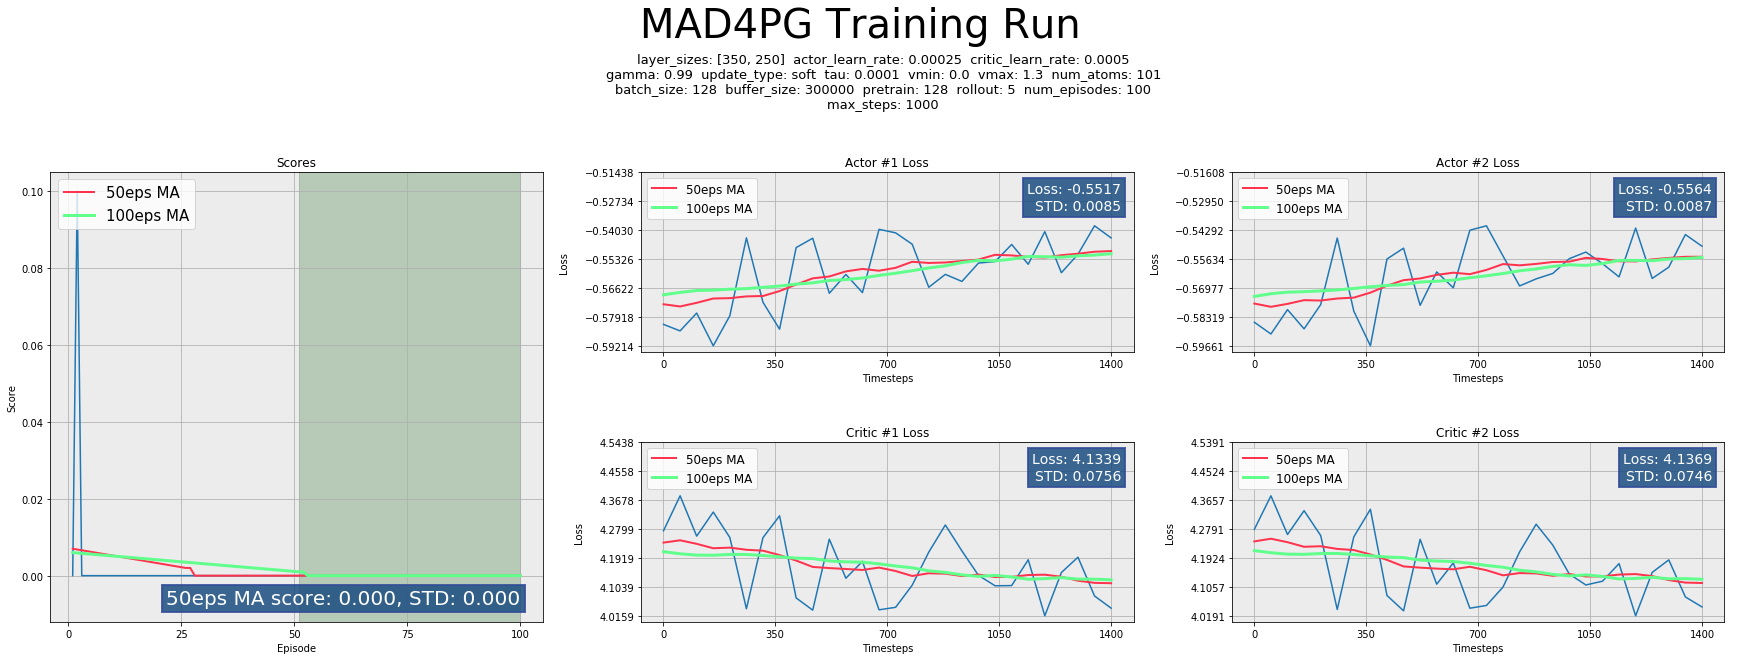

In [15]:
train(multi_agent, args, env, saver)

In [16]:
# Close the environment
env.close()

## The Model

Before getting into the Agent, let's quickly review the Neural Network model, which is quite straightforward but adds a small twist in order to esimate the continuous action space!

```python
WEIGHT_LOW = -3e-2
WEIGHT_HIGH = 3e-2

def initialize_weights(net, low, high):
    for param in net.parameters():
        param.data.uniform_(low, high)
```

>These networks perform best, as describe in the paper, with uniformly distributed small values for their initial weights. The network is quite sensitive to large initial weights and will learn at a much slower and less stable rate if not initialized.


```python
class ActorNet(nn.Module):
    """
    Actor network that approximates the non-linear function π(θ)
    """
    def __init__(self,
                 layer_sizes,
                 state_size,
                 action_size,
                 weight_low = WEIGHT_LOW,
                 weight_high = WEIGHT_HIGH):
        super(ActorNet, self).__init__()

        #currently errors if user were to provide a custom layer_sizes array
        #with dimensions other than 2x1
        fc1, fc2 = layer_sizes

        self.fc1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.output = nn.Linear(fc2, action_size)
        initialize_weights(self, weight_low, weight_high)

    def forward(self, state):
        """
        Build a network that maps states -> actions.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.output(x)
        action = logits.tanh()
        return action
```

>The Actor network is quite straightforward. It takes in a state, and outputs values between -1 to 1 using a TANH activation function. No fancy layer normalization or dropout is needed. 

```python
class CriticNet(nn.Module):
    """
    Critic network that approximates the Value of the suggested Actions that
    come from the Actor network.

    Utilizes the actions as an input to the second hidden layer in order to
    approximate the continuous control problem.
    """

    def __init__(self,
                 layer_sizes,
                 state_size,
                 action_size,
                 num_atoms,
                 weight_low = WEIGHT_LOW,
                 weight_high = WEIGHT_HIGH):
        super(CriticNet, self).__init__()

        #currently errors if user were to provide a custom layer_sizes array
        #with dimensions other than 2x1
        fc1, fc2 = layer_sizes

        self.fc1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1 + action_size, fc2)
        self.output = nn.Linear(fc2, num_atoms)
        initialize_weights(self, weight_low, weight_high)

    def forward(self, state, actions, log=False):
        """
        Build a network that estimates the value of an action given the state.
        """

        x = F.relu(self.fc1(state))
        x = torch.cat([x, actions], dim=1)
        x = F.relu(self.fc2(x))
        logits = self.output(x)
        # Only calculate the type of softmax needed by the foward call, to save
        # a modest amount of calculation across 1000s of timesteps.
        if log:
            return F.log_softmax(logits, dim=-1)
        else:
            return F.softmax(logits, dim=-1)

```

>The Critic network takes in the `State` as an input, but as described in the paper, the `Actions` are then added into the network directly as weights, by concatenating with the first fully-connected layer. This allows the Critic to approximate a value function for a continuous action space!
>
>For the MAD4PG implementation, as based on MADDPG paper, the State and Actions consist of the combined Observations and Actions of all the agents, respectively. Thus, if each agent receives an observation of size \[24], and there are two agents, the State input to the critic network is of size \[48].
>
>Because this is a _distributional_ network, the Critic outputs not a value, but a probability distribution over `num_atoms` number of discrete probabilities. In order to turn the network values into probabilities, we take the Softmax of the logits.
>
>Because D4PG requires Cross-Entropy loss to compute the Critic backpropogation, this network also outputs the Log Softmax values for use with the Cross-Entropy equation. However, to save some small amount of computation, it only outputs whichever version is flagged.

## The Network/Agent

### The Agent modules are reviewed bit by bit.

### **Class Instantiation**
There are two classes associated with this reinforcement learning framework, a MAD4PG_Net, and a D4PG_Agent.
#### **MAD4PG Class**
 

```python
class MAD4PG_Net:
    """
    This implementation uses a variant of OpenAI's MADDPG:
    https://arxiv.org/abs/1706.02275
    but utilizes D4PG as a base algorithm in what I will call MAD4PG.
    """

    def __init__(self, env, args):
        """
        Initialize a MAD4PG network.
        """

        self.framework = "MAD4PG"
        self.t_step = 0
        self.episode = 1
        self.avg_score = 0

        self.C = args.C
        self._e = args.e
        self.e_min = args.e_min
        self.e_decay = args.e_decay
        self.anneal_max = args.anneal_max
        self.update_type = args.update_type
        self.tau = args.tau
        self.state_size = env.state_size
        self.action_size = env.action_size
```

> #### Agents/Buffer creation
>Initialize all of the agents as required for the environment. Copy the parameters from the active networks to target networks.
>There is only a single ReplayBuffer for this multi-agent network. 

```python        
        # Create all the agents to be trained in the environment
        self.agent_count = env.agent_count
        self.agents = [D4PG_Agent(self.state_size,
                       self.action_size,
                       args,
                       self.agent_count)
                       for _ in range(self.agent_count)]
        self.batch_size = args.batch_size

        # Set up memory buffers, currently only standard replay is implemented
        self.memory = ReplayBuffer(args.device,
                                   args.buffer_size,
                                   args.gamma,
                                   args.rollout,
                                   self.agent_count)
        self.memory.init_n_step()

        for agent in self.agents:
            self.update_networks(agent, force_hard=True)
```

#### **D4PG Class**

```python
class D4PG_Agent:
    """
    D4PG utilizes distributional value estimation, n-step returns,
    prioritized experience replay (PER), distributed K-actor exploration,
    and off-policy actor-critic learning to achieve very fast and stable
    learning for continuous control tasks.

    This version of the Agent is written to interact with Udacity's
    Collaborate/Compete environment featuring two table-tennis playing agents.
    """

    def __init__(self, state_size, action_size, args,
                 agent_count = 1,
                 l2_decay = 0.0001):
        """
        Initialize a D4PG Agent.
        """

        self.framework = "D4PG"
        self.device = args.device
        self.eval = args.eval

        self.actor_learn_rate = args.actor_learn_rate
        self.critic_learn_rate = args.critic_learn_rate
        self.gamma = args.gamma
        self.rollout = args.rollout
        self.num_atoms = args.num_atoms
        self.vmin = args.vmin
        self.vmax = args.vmax
        self.atoms = torch.linspace(self.vmin,
                                    self.vmax,
                                    self.num_atoms).to(self.device)
        self.atoms = self.atoms.unsqueeze(0)
```


> #### Network creation
> Each agent maintains its own networks. There is no ReplayBuffer in the agent itself.

```python
        #                    Initialize ACTOR networks                         #
        self.actor = ActorNet(args.layer_sizes,
                              state_size,
                              action_size).to(self.device)
        self.actor_target = ActorNet(args.layer_sizes,
                                     state_size,
                                     action_size).to(self.device)
        self.actor_optim = optim.Adam(self.actor.parameters(),
                                      lr=self.actor_learn_rate,
                                      weight_decay=l2_decay)

        #                   Initialize CRITIC networks                         #
        c_input_size = state_size * agent_count
        c_action_size = action_size * agent_count
        self.critic = CriticNet(args.layer_sizes,
                                c_input_size,
                                c_action_size,
                                self.num_atoms).to(self.device)
        self.critic_target = CriticNet(args.layer_sizes,
                                       c_input_size,
                                       c_action_size,
                                       self.num_atoms).to(self.device)
        self.critic_optim = optim.Adam(self.critic.parameters(),
                                       lr=self.critic_learn_rate,
                                       weight_decay=l2_decay)
```

### **FILL MEMORY**

#### **`MAD4PG_Net.initialize_memory()`**
>Perform a basic loop through the environment for **`pretrain`** number of steps by collecting experiences with random actions. 

```python
def initialize_memory(self, pretrain_length, env):
    """
    Fills up the ReplayBuffer memory with PRETRAIN_LENGTH number of
    experiences before training begins.
    """

    if self.memlen >= pretrain_length:
        print("Memory already filled, length: {}".format(len(self.memory)))
        return
    interval = max(10, int(pretrain_length/25))
    print("Initializing memory buffer.")
    obs = env.states
    while self.memlen < pretrain_length:
        actions = np.random.uniform(-1, 1, (self.agent_count,
                                            self.action_size))
        next_obs, rewards, dones = env.step(actions)
        self.store((obs, next_obs, actions, rewards, dones))
        obs = next_obs
        if np.any(dones):
            env.reset()
            obs = env.states
            self.memory.init_n_step()
        if self.memlen % interval == 1 or self.memlen >= pretrain_length:
            print("...memory filled: {}/{}".format(self.memlen,
                                                   pretrain_length))
    print("Done!")
```

### **ACT**

#### **`MAD4PG_Net.act()`**
>An action is chosen via the Actor network, and then gaussian noise is added. The gaussian noise is scaled by the `E` parameter which is annealed on a schedule curve, reviewed later in the notebook.
>
>If running in `eval()` mode, then no noise is added and the network's actions are used.

```python
def act(self, obs, training=True):
    """
    For each agent in the MAD4PG network, choose an action from the ACTOR
    """

    assert len(obs) == len(self.agents), "Num OBSERVATIONS does not match \
                                          num AGENTS."
    with torch.no_grad():
        actions = np.array([agent.act(o) for agent, o in zip(self.agents, obs)])
    if training:
        actions += self._gauss_noise(actions.shape)
    return np.clip(actions, -1, 1)
```

#### **`D4PG_Agent.act()`**

>Because the Actor in D4PG/DDPG is _deterministic_, the action selection is quite straightforward. 

```python
def act(self, obs, eval=False):
    """
    Choose an action using a policy/ACTOR network π.
    """

    obs = obs.to(self.device)
    with torch.no_grad():
        actions = self.actor(obs).cpu().numpy()
    return actions
```



### **STORE**

#### **`MAD4PG_Net.store()`**
>This implementation of the MAD4PG network simplifies some operation from the previous incarnation of D4PG. The store step simply sends an experience to the ReplayBuffer, where it is processed into an N-Step Memory.

```python
    def store(self, experience):
        """
        Store an experience tuple in the ReplayBuffer
        """

        self.memory.store(experience)
```

### **LEARN**

The `learn` step must be broken into two portions for a multi-agent network. In MADDPG, each agent processes the observations and actions of all the other agents, so in the MAD4PG_Net object we need to concatenate the states for processing, before passing to each agent for learning. 

#### **`MAD4PG.learn()`**

>First we sample a batch of memories to process. The historical actions have already been concatenated into a single tensor before storage. These experiences consist of STATE<sub>t</sub>, ACTION<sub>t</sub>, REWARD<sub>t->t+N</sub>, NEXT_STATE<sub>t+N+1</sub>. Where N=`rollout`.
>
>We collect _target_ and _predicted_ actions from the target and active networks, respectively, and then concatenate the results into a single tensor of size \[batchsize, action_size * agent_count].
>
>Once these have been calculated, we no longer need the separate observations because the Critic network needs the combined observations. So we adjust the _observations_ and _next_observations_ tensors into shape \[batchsize, state_size * agent_count]
>
>The results are fed through each agent's `learn()` method, and the networks are then updated from time to time.
            
``` python            
def learn(self):
    """
    Perform a learning step on all agents in the network.
    """

    self.t_step += 1

    # Sample from replay buffer, which already has nstep rollout calculated.
    batch = self.memory.sample(self.batch_size)
    obs, next_obs, actions, rewards, dones = batch

    # Gather and concatenate actions because critic networks need ALL
    # actions as input, the stored actions were concatenated before storing
    # in the buffer
    target_actions = [agent.actor_target(next_obs[i]) for i, agent in
                      enumerate(self.agents)]
    predicted_actions = [agent.actor(obs[i]) for i, agent in
                         enumerate(self.agents)]
    target_actions = torch.cat(target_actions, dim=-1)
    predicted_actions = torch.cat(predicted_actions, dim=-1)

    # Change state data from [agent_count, batch_size]
    # to [batchsize, state_size * agent_count]
    # because critic networks need to ALL observations as input
    obs = obs.transpose(1,0).contiguous().view(self.batch_size, -1)
    next_obs = next_obs.transpose(1,0).contiguous().view(self.batch_size,-1)

    # Perform a learning step for each agent using concatenated data as well
    # as unique-perspective data where algorithmically called for
    for i, agent in enumerate(self.agents):
        agent.learn(obs, next_obs, actions, target_actions,
                    predicted_actions, rewards[i], dones[i])
        self.update_networks(agent)
```

#### **`D4PG_Agent.learn()`**

>Each agent performs a D4PG update step using the processed SARS' data provided from the parent network. 
>
>* Generate the Log probabilities from the online critic network using the stored states and actions.
>
>* Calculate the value distribution of the offline critic network using the next_states and predicted actions of those states.
>           
>* Calculate the Cross-Entropy loss using the above two steps and use this to backpropogate through the online critic network.
>
>* Calculate the value distribution from the online critic network and backpropogate the inverse value through the actor network as gradient ascent.
>
>* The current loss values are kept as network properties for later logging every so often.
      


```python
def learn(self, obs, next_obs, actions, target_actions, predicted_actions,
          rewards, dones):
    """
    Performs a distributional Actor/Critic calculation and update.
    Actor πθ and πθ'
    Critic Zw and Zw' (categorical distribution)
    """

    # Calculate log probability DISTRIBUTION w.r.t. stored actions
    log_probs = self.critic(obs, actions, log=True)
    # Calculate TARGET distribution/project onto supports (Yi)
    target_probs = self.critic_target(next_obs, target_actions).detach()
    target_dist = self._categorical(rewards, target_probs, dones)#.detach()
    # Calculate the critic network LOSS (Cross Entropy)
    critic_loss = -(target_dist * log_probs).sum(-1).mean()


    # Predict value DISTRIBUTION using Zw w.r.t. action predicted by πθ
    probs = self.critic(obs, predicted_actions)
    # Mult value probs by atom values and sum across columns to get Q-Value
    expected_reward = (probs * self.atoms).sum(-1)
    # Calculate the actor network LOSS (Policy Gradient)
    actor_loss = -expected_reward.mean()

    # Perform gradient ascent
    self.actor_optim.zero_grad()
    actor_loss.backward(retain_graph=True)
    self.actor_optim.step()

    # Perform gradient descent
    self.critic_optim.zero_grad()
    critic_loss.backward()
    self.critic_optim.step()

    self.actor_loss = actor_loss.item()
    self.critic_loss = critic_loss.item()

def _categorical(self, rewards, probs, dones):
    """
    Returns the projected value distribution for the input state/action pair

    While there are several very similar implementations of this Categorical
    Projection methodology around github, this function owes the most
    inspiration to Zhang Shangtong and his excellent repository located at:
    https://github.com/ShangtongZhang
    """

    # Create local vars to keep code more concise
    vmin = self.vmin
    vmax = self.vmax
    atoms = self.atoms
    num_atoms = self.num_atoms
    gamma = self.gamma
    rollout = self.rollout

    # rewards/dones shape from [batchsize,] to [batchsize,1]
    rewards = rewards.unsqueeze(-1)
    dones = dones.unsqueeze(-1).type(torch.float)

    delta_z = (vmax - vmin) / (num_atoms - 1)

    projected_atoms = rewards + gamma**rollout * atoms * (1 - dones)
    projected_atoms.clamp_(vmin, vmax)
    b = (projected_atoms - vmin) / delta_z

    # It seems that on professional level GPUs (for instance on AWS), the
    # floating point math is accurate to the degree that a tensor printing
    # as 99.00000 might in fact be 99.000000001 in the backend, perhaps due
    # to binary imprecision, but resulting in 99.00000...ceil() evaluating
    # to 100 instead of 99. Forcibly reducing the precision to the minimum
    # seems to be the only solution to this problem, and presents no issues
    # to the accuracy of calculating lower/upper_bound correctly.
    precision = 1
    b = torch.round(b * 10**precision) / 10**precision
    lower_bound = b.floor()
    upper_bound = b.ceil()

    m_lower = (upper_bound + (lower_bound == upper_bound).float() - b) * probs
    m_upper = (b - lower_bound) * probs

    projected_probs = torch.tensor(np.zeros(probs.size())).to(self.device)

    for idx in range(probs.size(0)):
        projected_probs[idx].index_add_(0, lower_bound[idx].long(), m_lower[idx].double())
        projected_probs[idx].index_add_(0, upper_bound[idx].long(), m_upper[idx].double())
    return projected_probs.float()
```

### EPSILON

#### **`MAD4PG_Net.e()`**

>This codebase has a more mature implementation for `E` than my previous projects. It uses a modified TANH curve to provide a falloff near the min/max values that control the curve. The rate of change is controlled by the `score` that the agent has been receiving, averaged over a number of episodes, **50** in this implementation. By averaging over the previous episode scores, the rate of change in `E` can be smoothed an ensure that exploration is not reduced too quickly. The agent will need to continue to get stable scores for the value to continue to reduce.

```python
@property
def e(self):
    """
    This property ensures that the annealing process is run every time that
    E is called.

    Anneals the epsilon rate down to a specified minimum to ensure there is
    always some noisiness to the policy actions. Returns as a property.

    Uses a modified TANH curve to roll off the values near min/max.
    """

    ylow = self.e_min
    yhigh = self._e

    xlow = 0
    xhigh = self.anneal_max

    steep_mult = 8

    steepness = steep_mult / (xhigh - xlow)
    offset = (xhigh + xlow) / 2
    midpoint = yhigh - ylow

    x = np.clip(self.avg_score, 0, xhigh)
    x = steepness * (x - offset)
    e = ylow + midpoint / (1 + np.exp(x))
    return e    

def _gauss_noise(self, shape):
    """
    Returns the epsilon scaled noise distribution for adding to Actor
    calculated action policy.
    """

    n = np.random.normal(0, 1, shape)
    return self.e*n
```

##### Let's take a quick look at what this curve looks like in practice
We want the value of `E` to be at it's maximum at a reward of 0, where no learning has taken place or the agent(s) need to improve fully. 

The values defined on the commandline bound the remainder of the curve:
`e_min` is the minimum boundary towards which `e` will anneal to over time.
`e` is the maximum boundary of the curve.
`anneal_max` is the value of the score at which `e` is annealed to minimum.

By defining the annealing function in this way, we ensure that as the agents improve their performance, they are discouraged from continuing to explore too much, thus reducing the risk of catastrophic forgetting or instability.

Not that because this is a variant of a TANH curve, the curve will _approach_ the boundaries but not reach them. If it causes you problems that a parameter `e=0.3` returns a value of 0.2954... _you're doing something else wrong and this isn't the cause of your problems._

One major caveat here is that it requires some knowledge of the environment and what a _good_ score constitutes. In a black-box environment, it would be difficult to anneal the parameter in this way. In such an environment, it might be more effective to maintain a constant rate of exploration, or implement some sort of stochastic process.

Below are two settings and the resulting curves of the example parameters. 

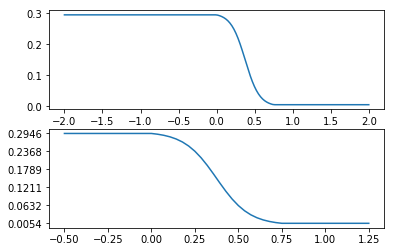

In [17]:
xlow = 0
xhigh = args.anneal_max = 0.75
ylow = args.e_min = 0
yhigh = args.e = 0.3
graph_e([ylow, yhigh, xlow, xhigh])

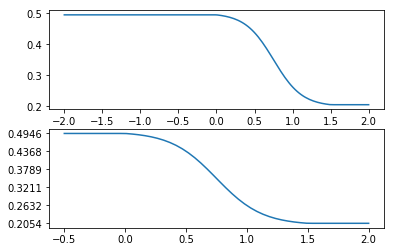

In [18]:
xlow = 0
xhigh = args.anneal_max = 1.5
ylow = args.e_min = .2
yhigh = args.e = 0.5
graph_e([ylow, yhigh, xlow, xhigh])

### BOILERPLATE
The below methods perform basic tasks that are explained adequately in their commenting.

**MAD4PG_Net().** ...

```python                
def new_episode(self, scores):
    """
    Handle any cleanup or steps to begin a new episode of training.
    """

    # Keep track of an average score for use with annealing epsilon,
    # TODO: this currently lives in new_episode() because we only want to
    # update epsilon each episode, not each timestep, currently. This should
    # be further investigate about moving this into the epsilon property
    # itself instead of here
    avg_across = np.clip(len(scores), 1, 50)
    self.avg_score = np.array(scores[-avg_across:]).mean()

    self.memory.init_n_step()
    self.episode += 1

def update_networks(self, agent, force_hard=False):
    """
    Updates the network using either DDPG-style soft updates (w/ param TAU),
    or using a DQN/D4PG style hard update every C timesteps.
    """

    if self.update_type == "soft" and not force_hard:
        self._soft_update(agent.actor, agent.actor_target)
        self._soft_update(agent.critic, agent.critic_target)
    elif self.t_step % self.C == 0 or force_hard:
        self._hard_update(agent.actor, agent.actor_target)
        self._hard_update(agent.critic, agent.critic_target)

def _soft_update(self, active, target):
    """
    Slowly updated the network using every-step partial network copies
    modulated by parameter TAU.
    """

    for t_param, param in zip(target.parameters(), active.parameters()):
        t_param.data.copy_(self.tau*param.data + (1-self.tau)*t_param.data)

def _hard_update(self, active, target):
    """
    Fully copy parameters from active network to target network. To be used
    in conjunction with a parameter "C" that modulated how many timesteps
    between these hard updates.
    """

    target.load_state_dict(active.state_dict())

@property
def memlen(self):
    """
    Returns length of memory buffer as a property.
    """

    return len(self.memory)
```

## Replay Buffer

### A quick look at N-Step Rollout

Bootstrapping by utilizing multiple steps of experience in each learning step is hugely beneficial. Much was learned from the previous Project \#2 _Reacher_. This Buffer code is cleaner, and faster, than previously.

>This buffer stacks each experience in a Deque of `maxlen=rollout` length. Where `rollout` equals the N of N-Step Bootstrapping.
>
>Once `rollout` experiences are stored in the Deque, then a memory is stored in the full buffer, utilizing the first state, last next_state, and cumulative rewards. This implementation properly handles _terminal states_.

```python
class ReplayBuffer:
    """
    Standard replay buffer to hold memories for later learning. Utilizes 
    N-Step Rollout/Boostrapping.
    """
    def __init__(self, device, buffer_size=100000, gamma=0.99, rollout=5,
                 agent_count=1):
        self.buffer = deque(maxlen=buffer_size)
        self.device = device
        self.gamma = gamma
        self.rollout = rollout
        self.agent_count = agent_count

    def store(self, experience):
        """
        Once the n_step memory holds ROLLOUT number of sars' tuples, then a full
        memory can be added to the ReplayBuffer.
        """

        if self.rollout > 1:
            self.n_step.append(experience)
            # Abort if ROLLOUT steps haven't been taken in a new episode
            if len(self.n_step) < self.rollout:
                return
            experience = self._n_stack()

        obs, next_obs, actions, rewards, dones = experience
        actions = torch.from_numpy(np.concatenate(actions)).float()
        rewards = torch.from_numpy(rewards).float()
        dones = torch.tensor(dones).float()
        self.buffer.append((obs, next_obs, actions, rewards, dones))

    def sample(self, batch_size):
        """
        Return a sample of size BATCH_SIZE as a tuple.
        """

        batch = random.sample(self.buffer, k=batch_size)
        obs, next_obs, actions, rewards, dones = zip(*batch)

        # Transpose the num_agents and batch_size, for easy indexing later
        # e.g. from 64 samples of 2 agents each, to 2 agents with 64 samples
        obs = torch.stack(obs).transpose(1,0).to(self.device)
        next_obs = torch.stack(next_obs).transpose(1,0).to(self.device)
        actions = torch.stack(actions).to(self.device)
        rewards = torch.stack(rewards).transpose(1,0).to(self.device)
        dones = torch.stack(dones).transpose(1,0).to(self.device)
        return (obs, next_obs, actions, rewards, dones)

    def init_n_step(self):
        """
        Creates (or rezeroes an existing) deque to handle nstep returns.
        """

        self.n_step = deque(maxlen=self.rollout)

    def _n_stack(self):
        """
        Takes a stack of experience tuples of depth ROLLOUT, and calculates
        the discounted real rewards, then returns the next_obs at ROLLOUT
        timesteps to be used with a nstep trajectory structure Q value.
        """

        obs, next_obs, actions, rewards, dones = zip(*self.n_step)

        summed_rewards = rewards[0]
        for i in range(1, self.rollout):
            summed_rewards += self.gamma**i * rewards[i]
            if np.any(dones[i]):
                break

        obs = obs[0]
        nstep_obs = next_obs[i]
        actions = actions[0]
        dones = dones[i]
        return (obs, nstep_obs, actions, summed_rewards, dones)

    def __len__(self):
        return len(self.buffer)
```

# Wrapping it up

There were two primary challenges in completing this task:
* MADDPG implementation requires each agent to have access to the full state via the combined obersations of all agents, and all actions
    * Initially I did not fully understand this and ran many trials without any convergence whatsoever (in fact, never even achieving an average score of +0.1) 
    * I do not fully understand the theoretical groundwork for why the agent cannot learn from its own observations alone, and need to study this further, as well as policy approximation for instances where the agent does _not_ have access to all observations. 
* This task was quite unstable and sensitive to parameter tuning. It also took a very long time to run, generally needing at least 1 hour of training before even beginning to see if the agent was learning, and 2-3+ hours to see if it was converging to a goal-score.

I learned a lot about troubleshooting and methodically testing parameters for effectiveness by working my way through this. This project also left me with a great deal of further study to delve into next, which is a plus.

While I feel I have achieved a strong grasp of the principals behind the projects and topics covered in this class, I am empowered with an understanding of how much more there is to learn, and a great desire to do so.

The Udacity _Deep Reinforcement Learning Nanodegree_ program has been one of the better learning experiences of my life. I can look back over just a few short months and it's difficult to comprehend how much I have learned. I have a very deep interest in pursuing further work and a career in this field and I am thankful to have had this great introduction to the amazing world of Reinforcement Learning.

To run this project as it was intended, please review the README.md in the github repository located at:
https://github.com/whiterabbitobj/Udacity-DeepRL/tree/master/Projects/Collaborate_Compete

The agent params have already been optimized in their defaults and this project can be run as simply as:  
**`python main.py`**   
to achieve good, clean results.

Thanks for reading!

Please feel free to contact me with any bugs, questions, or comments.